In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
pd.set_option("display.max_columns", 200)


In [2]:
df_train = pd.read_csv("C:\\Users\\dipes\\Desktop\\election-analytics-nepal-2082\\data\\processed\\training_pr_base.csv")
df = df_train.copy()

In [4]:
df["under_40_ratio"] = df["age_18-29_ratio"] + df["age_30-39_ratio"]
df["40-60_ratio"] = df["age_40-49_ratio"] + df["age_50-59_ratio"]
df["SEE-Inter"] = df["SLC or SEE % 2078"]+df["Intermediate & equivalent % 2078"]
df["Grad+"] = df["Graduate & equivalent % 2078"]+df["Post graduate equivalent & above % 2078"]

In [7]:
FEATURES = [
    "vote_share_lag",
    "is_new_party",
    "IS_Major?",
    "IS_ALTERNATIVE_FORCE?",
    "Was_Part_Of_Ousted_Government?",
    "GenZ_and_Youth_Favored?",

    # Demographics
    "under_40_ratio",
    "40-60_ratio",
    "female_ratio",

    # Education
    "Literacy Rate 2078",
    "SEE-Inter",
    "Grad+",

    # Migration
    "Absent rate within country 2078",
    "Absent rate abroad 2078",

    # Mobilization
    "valid_turnout",
    "valid_turnout_lag",

    # Digital
    "leader_following_log",
]
TARGET = "vote_share_change"
GROUP = "district_id"

In [8]:
X = df[FEATURES]
y = df[TARGET]
groups = df[GROUP]

In [9]:
sample_weight = df["vote_share_lag"] + 0.05

In [22]:
xgb_params = {
    "objective": "reg:squarederror",
    "n_estimators": 500,
    "learning_rate": 0.03,
    "max_depth": 4,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 1.0,
    "reg_lambda": 1.0,
    "random_state": 42,
}


In [23]:
gkf = GroupKFold(n_splits=2)

oof_preds = np.zeros(len(df))

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"Fold {fold+1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    w_train = sample_weight.iloc[train_idx]

    model = xgb.XGBRegressor(**xgb_params)

    model.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    oof_preds[val_idx] = model.predict(X_val)


Fold 1
Fold 2


In [24]:
mae = mean_absolute_error(y, oof_preds)
rmse = np.sqrt(mean_squared_error(y, oof_preds))

print(f"Tree MAE (vote_share_change): {mae:.3f}")
print(f"Tree RMSE (vote_share_change): {rmse:.3f}")


Tree MAE (vote_share_change): 1.085
Tree RMSE (vote_share_change): 2.524


In [25]:
df["tree_pred_change"] = oof_preds
df["tree_pred_vote_share"] = (
    df["vote_share_lag"] + df["tree_pred_change"]
).clip(0, 100)


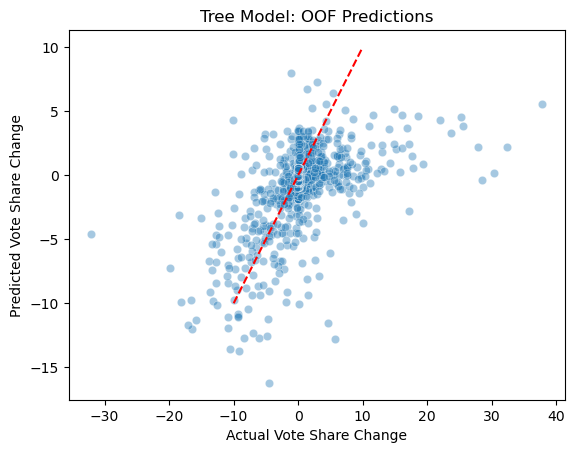

In [26]:
sns.scatterplot(x=y, y=oof_preds, alpha=0.4)
plt.plot([-10,10], [-10,10], "r--")
plt.xlabel("Actual Vote Share Change")
plt.ylabel("Predicted Vote Share Change")
plt.title("Tree Model: OOF Predictions")
plt.show()


In [29]:
model = xgb.XGBRegressor(**xgb_params)
treemodel = model.fit(
    X,y,
    verbose=False
)

In [32]:
df82 = pd.read_csv("C:\\Users\\dipes\\Desktop\\election-analytics-nepal-2082\\data\\processed\\base_pr_2082.csv")

In [33]:
temp = df[["district_id","valid_turnout"]].drop_duplicates().reset_index(drop =True)

In [34]:
df82 = df82.merge(temp,on = "district_id", how = "left")

In [35]:
df82["under_40_ratio"] = df82["age_18-29_ratio"] + df82["age_30-39_ratio"]
df82["40-60_ratio"] = df82["age_40-49_ratio"] + df82["age_50-59_ratio"]
df82["SEE-Inter"] = df82["SLC or SEE % 2078"]+df82["Intermediate & equivalent % 2078"]
df82["Grad+"] = df82["Graduate & equivalent % 2078"]+df82["Post graduate equivalent & above % 2078"]

In [36]:
X_82 = df82[FEATURES]

In [37]:
df82["pred_vote_share"] = df82["vote_share_lag"] + treemodel.predict(X_82)

In [38]:
temp2 = df82[["party_id","district_id","total_voters","valid_turnout","vote_share_lag","pred_vote_share"]]

In [43]:
temp2.head(15)

,party_id,district_id,total_voters,valid_turnout,vote_share_lag,pred_vote_share,Votes
0,P001,1,90327,52.41,42.369621,39.646391,18768.752436
1,P002,1,90327,52.41,34.007651,33.852818,16026.052917
2,P003,1,90327,52.41,14.499989,11.639762,5510.307571
3,P004,1,90327,52.41,2.115888,5.126099,2426.714892
4,P005,1,90327,52.41,1.376732,0.790041,374.008416
5,P006,1,90327,52.41,1.560440,1.520915,720.006969
6,P007,1,90327,52.41,0.056193,2.114706,1001.109898
7,P009,1,90327,52.41,0.010806,-0.334474,-158.341424
8,P010,1,90327,52.41,0.049709,0.464426,219.860810
9,P011,1,90327,52.41,0.051871,0.083091,39.335792


In [39]:
temp2["Votes"] = temp2["total_voters"]*temp2["valid_turnout"]*temp2["pred_vote_share"]/10000

C:\Users\dipes\AppData\Local\Temp\ipykernel_11000\1858784566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2["Votes"] = temp2["total_voters"]*temp2["valid_turnout"]*temp2["pred_vote_share"]/10000


In [40]:
temp3 = (
    temp2[['party_id', 'Votes']]
    .groupby('party_id', as_index=False)['Votes']
    .sum()
    .sort_values('Votes', ascending=False)
)

In [41]:
temp3.head(20)

,party_id,Votes
1,P002,2.466494e+06
0,P001,2.349834e+06
3,P004,1.914301e+06
2,P003,1.287661e+06
44,P046,1.116196e+06
55,P057,8.431706e+05
6,P007,6.602858e+05
4,P005,6.415214e+05
12,P014,4.984795e+05
5,P006,3.353893e+05
